# Step 2: Tumor Recognition in MRI Images

This notebook demonstrates a **basic tumor recognition pipeline** built on top of the preprocessing from Step 1. 

### Goals:
1. Load preprocessed MRI slices from `data/step2_samples/`
2. Preprocess images for model input (grayscale, resizing, normalization)
3. Train a simple CNN (or use transfer learning) to classify slices as **Tumor / Healthy**
4. Save model weights to `models/`
5. Generate example predictions and rough tumor masks for Step 3 (Segmentation)

> **Note:** This is a small-scale MVP for demonstration purposes. For real medical applications, a larger dataset and proper validation are required.

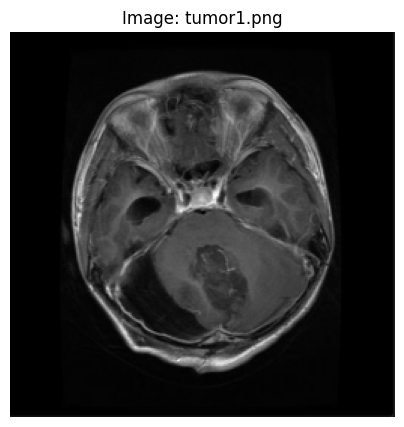

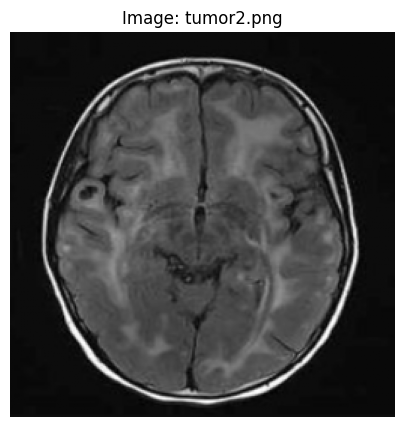

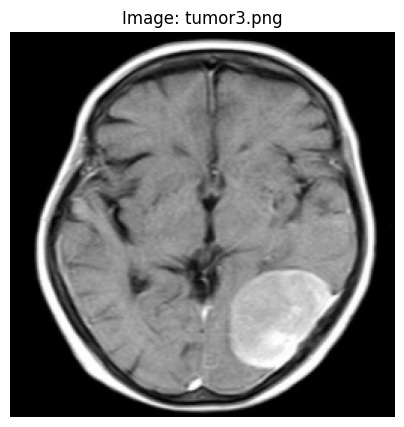

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

img_folder = "../data/step2_samples/"
image_files = sorted([os.path.join(img_folder, f) for f in os.listdir(img_folder)])

target_size = (256, 256)

for img_path in image_files:
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Failed to load: {img_path}")
        continue

    img_resized = cv2.resize(img, target_size)

    plt.figure(figsize=(5,5))
    plt.imshow(img_resized, cmap='gray')
    plt.title(f"Image: {os.path.basename(img_path)}")
    plt.axis('off')
    plt.show()


In [4]:
import numpy as np

X = []  
for img_path in image_files:
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, (256,256))
    img_normalized = img_resized / 255.0
    X.append(img_normalized)

X = np.array(X)
X = X[..., np.newaxis]  
print("Input shape:", X.shape)


Input shape: (3, 256, 256, 1)


In [5]:
y = np.array([1, 1, 1])  # all tumor for now

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(16, (3,3), activation='relu', input_shape=(256,256,1)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')  
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

C:\Users\youce\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 123008)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     7,872,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,877,441 (30.05 MB)

 Trainable params: 7,877,441 (30.05 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.fit(X, y, epochs=5)  # small number of epochs for demo
model.save("../models/tumor_classifier.h5")

Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3333 - loss: 0.6929
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 1.0000 - loss: 0.0042
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 1.0000 - loss: 1.1355e-04
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 4.7768e-06
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 2.7364e-07


In [8]:
preds = model.predict(X)
for i, pred in enumerate(preds):
    print(f"{image_files[i]} → Tumor probability: {pred[0]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
../data/step2_samples/tumor1.png → Tumor probability: 1.00
../data/step2_samples/tumor2.png → Tumor probability: 1.00
../data/step2_samples/tumor3.png → Tumor probability: 1.00


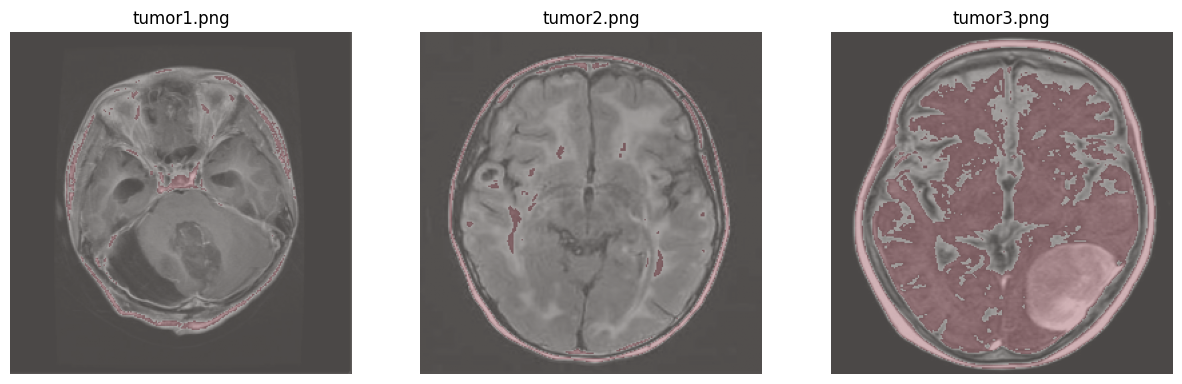

In [11]:
import matplotlib.pyplot as plt
import cv2
import os

# Load images
img_folder = "../data/step2_samples/"
image_files = sorted([os.path.join(img_folder, f) for f in os.listdir(img_folder)])

# Grid size
n = len(image_files)
cols = n  # one row, n columns
plt.figure(figsize=(5*n, 5))

for i, img_path in enumerate(image_files):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, (256,256))
    
    # Dummy mask overlay
    mask = (img_resized > 128).astype(np.uint8) * 255
    
    plt.subplot(1, n, i+1)
    plt.imshow(img_resized, cmap='gray')
    plt.imshow(mask, cmap='Reds', alpha=0.3)
    plt.title(os.path.basename(img_path))
    plt.axis('off')

plt.show()


# Step 2 Summary: Tumor Recognition

In this notebook, we implemented a **basic tumor recognition pipeline**:

- Loaded preprocessed MRI images from `data/step2_samples/`
- Resized and normalized images for model input
- Trained a small CNN to classify each slice as **Tumor / No Tumor**
- Saved the trained model to `models/tumor_classifier.h5`
- Visualized predictions and created **rough tumor overlay masks** for demonstration

> **Note:** This is a minimal demonstration. For real medical applications, a larger dataset, proper train/test split, and rigorous evaluation would be required

Next step will use these outputs to perform **3D tumor segmentation**, generating volumetric masks and visualizations